# A Machine Learning Approach to Facies Classification Using Well Logs
##### <a href="https://home.deib.polimi.it/bestagini/">Paolo Bestagini</a>, Vincenzo Lipari and Stefano Tubaro - Politecnico di Milano, Italy

In the following, we report the code we developed to solve the facies classification problem described at https://github.com/seg/2016-ml-contest. Please refer to the original webpage for all the details about the challenge and download the used dataset (i.e., 'facies_vectors.csv').


## Script initialization
Let us import the used packages and define some parameters.

In [1]:
# Import
from __future__ import division
%matplotlib inline
from utils import plot_confusion_matrix
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.signal import medfilt

In [2]:
# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

## Load data
Let us load training data and store features, labels and other data into numpy arrays.

In [3]:
# Load data from file
data = pd.read_csv('facies_vectors.csv')  # data file should be downloaded from https://github.com/seg/2016-ml-contest

In [4]:
# Store features and labels
X = data[feature_names].values  # features
y = data['Facies'].values  # labels

In [5]:
# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

In [6]:
# Sort data according to depth for each well
for w_idx, w in enumerate(np.unique(well)):
    X_well = X[well == w]
    X[well == w] = X_well[np.argsort(depth[well == w])]
    depth[well == w] = np.sort(depth[well == w])

In [7]:
# Fill missing PE values using feature imputation
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

## Feature augmentation
Let us define routines for feature augmentation 

In [8]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
    
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [9]:
# Feature augmentation function
def augment_features(X, well, depth):
    
    # Augment features
    padded_rows = []
    X_aug = np.zeros((X.shape[0], X.shape[1]*2))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X[w_idx, :], X_aug_grad), axis=1)
        padded_rows.append(w_idx[-1])
    
    return X_aug, padded_rows

In [10]:
# Augment features
X_aug, padded_rows = augment_features(X, well, depth)

In [11]:
# Add higher degree terms and interaction terms to the model
deg = 2
poly = preprocessing.PolynomialFeatures(deg, interaction_only=False)
X_aug = poly.fit_transform(X_aug)
X_aug = X_aug[:,1:]

## Generate training and test data splits
In the following we implement leave-one-well-out strategy for 10-folds cross-validation.

In [12]:
# Initialize model selection methods
lpgo = LeavePGroupsOut(1)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (data['Well Name'][split['train']].unique()))
    print('    validation: %s' % (data['Well Name'][split['val']].unique()))

Split 0
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D']
Split 1
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE'
 'NOLAN' 'Recruit F9' 'NEWBY']
    validation: ['CHURCHMAN BIBLE']
Split 2
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN'
 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['CROSS H CATTLE']
Split 3
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['KIMZEY A']
Split 4
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['LUKE G U']
Split 5
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE'
 'NOLAN' 'Recruit F9' 'CHURCHMAN BIBLE']
    validation: ['NEWBY'

## Classifier definition
Let us deifine a training / testing routine based on a gradient boosting classifier.

In [13]:
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_v, well_v):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    # Train classifier
    clf = OneVsOneClassifier(GradientBoostingClassifier(loss='exponential',
                                        n_estimators=100,
                                        learning_rate=0.1, 
                                        max_features=np.min((10, X_tr.shape[1])),
                                        min_samples_leaf=5,
                                        min_samples_split=25,
                                        random_state=0,
                                        subsample=1,
                                        max_leaf_nodes=None, 
                                        verbose=0), n_jobs=-1)
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

## Test the proposed pipeline
Here we provide validation results of the proposed pipeline.


Average F1 score = 0.607


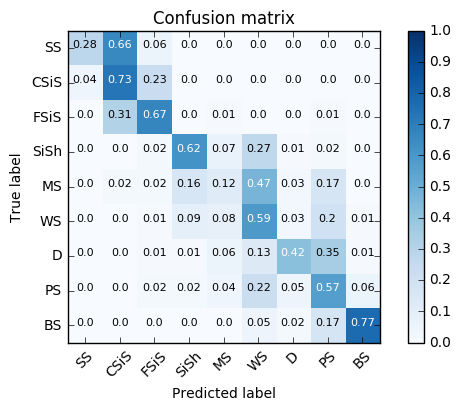

In [14]:
# For each data split
score_split = []
conf_mat_all = []
for split in split_list:

    # Remove padded rows
    split_train_no_pad = np.setdiff1d(split['train'], padded_rows)

    # Select training and validation data from current split
    X_tr = X_aug[split_train_no_pad, :]
    X_v = X_aug[split['val'], :]
    y_tr = y[split_train_no_pad]
    y_v = y[split['val']]

    # Select well labels for validation data
    well_v = well[split['val']]

    # Train and test
    y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v)

    # Score
    score = f1_score(y_v, y_v_hat, average='micro')
    score_split.append(score)
    conf_mat = confusion_matrix(y_v, y_v_hat, labels=np.arange(9)+1)
    conf_mat_all.append(conf_mat)
    
# Average scores
score_avg = np.mean(score_split)
print('\nAverage F1 score = %.3f' % score_avg)

# Confusion matrix
plot_confusion_matrix(np.sum(conf_mat_all, axis=0), classes=facies_names)

## Test the proposed pipeline without feature augmentation
In the following we provide results obtained without feature augmentation to prove its effectiveness.


Average F1 score = 0.549


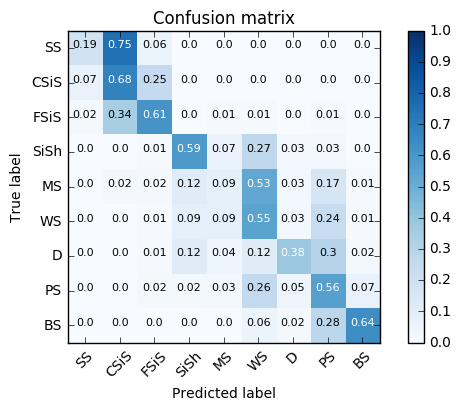

In [15]:
# For each data split
score_split = []
conf_mat_all = []
for split in split_list:
    
    # Select training and validation data from current split
    X_tr = X[split['train'], :]
    X_v = X[split['val'], :]
    y_tr = y[split['train']]
    y_v = y[split['val']]

    # Select well labels for validation data
    well_v = well[split['val']]
    
    # Train and test
    y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v)

    # Score
    score = f1_score(y_v, y_v_hat, average='micro')
    score_split.append(score)
    conf_mat = confusion_matrix(y_v, y_v_hat, labels=np.arange(9)+1)
    conf_mat_all.append(conf_mat)
    
# Average scores
score_avg = np.mean(score_split)
print('\nAverage F1 score = %.3f' % score_avg)

# Confusion matrix
plot_confusion_matrix(np.sum(conf_mat_all, axis=0), classes=facies_names)